In [18]:
%pip install pandas requests matplotlib

import pandas as pd
import requests
import matplotlib.pyplot as plt
from config import API_KEY

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# Function to fetch data from Nasdaq API
def fetch_stock_data(symbol, api_key):
    url = f"https://data.nasdaq.com/api/v3/datasets/WIKI/{symbol}.json"
    params = {
        'api_key': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['dataset']['data'], columns=data['dataset']['column_names'])

# Fetch data for AT&T, T-Mobile, and Verizon
symbols = {
    'AT&T': 'T',
    'T-Mobile': 'TMUS',
    'Verizon': 'VZ'
}

stock_data = {}
for company, symbol in symbols.items():
    stock_data[company] = fetch_stock_data(symbol, API_KEY)

# Combine the data into a single DataFrame for analysis
combined_data = pd.concat(stock_data.values(), keys=stock_data.keys())
combined_data.reset_index(level=0, inplace=True)
combined_data.rename(columns={'level_0': 'Company'}, inplace=True)

# Save the combined data to a CSV file for further analysis
combined_data.to_csv('combined_data.csv', index=False)

# Display the combined data to verify
combined_data.head()

,Company,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,AT&T,2018-03-27,34.85,35.2000,34.69,34.90,33198184.0,0.0,1.0,34.85,35.2000,34.69,34.90,33198184.0
1,AT&T,2018-03-26,35.06,35.2866,34.44,34.69,31281785.0,0.0,1.0,35.06,35.2866,34.44,34.69,31281785.0
2,AT&T,2018-03-23,35.37,35.9900,34.55,34.70,34260415.0,0.0,1.0,35.37,35.9900,34.55,34.70,34260415.0
3,AT&T,2018-03-22,35.95,36.0400,35.36,35.37,28063362.0,0.0,1.0,35.95,36.0400,35.36,35.37,28063362.0
4,AT&T,2018-03-21,36.34,36.5000,36.00,36.00,16776049.0,0.0,1.0,36.34,36.5000,36.00,36.00,16776049.0


In [20]:
# Convert the Date column to datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Sort the data by Company and Date
combined_data.sort_values(by=['Company', 'Date'], inplace=True)

# Handle missing values (if any)
combined_data.ffill(inplace=True)
combined_data.bfill(inplace=True)

# Verify the cleaned data
combined_data.head()


,Company,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
8491,AT&T,1984-07-19,59.75,59.87,59.38,59.38,77900.0,0.0,1.0,1.275248,1.277809,1.267351,1.267351,934800.0
8490,AT&T,1984-07-20,59.62,60.00,59.25,59.50,129800.0,0.0,1.0,1.272474,1.280584,1.264577,1.269913,1557600.0
8489,AT&T,1984-07-23,59.25,59.75,58.75,59.50,276100.0,0.0,1.0,1.264577,1.275248,1.253905,1.269913,3313200.0
8488,AT&T,1984-07-24,59.75,60.38,59.62,60.00,129100.0,0.0,1.0,1.275248,1.288694,1.272474,1.280584,1549200.0
8487,AT&T,1984-07-25,60.00,61.37,59.87,60.75,152400.0,0.0,1.0,1.280584,1.309824,1.277809,1.296591,1828800.0


In [21]:
# Filter the data to include only dates from 2017-01-01 to 2017-12-12
start_date = pd.Timestamp('2017-01-01')
end_date = pd.Timestamp('2017-12-12')
filtered_data = combined_data[(combined_data['Date'] >= start_date) & (combined_data['Date'] <= end_date)].copy()

# Extract year and quarter
filtered_data['Year'] = filtered_data['Date'].dt.year
filtered_data['Quarter'] = filtered_data['Date'].dt.to_period('Q')

# Define the colors for each company
colors = {'AT&T': 'Deepskyblue', 'T-Mobile': 'Fuchsia', 'Verizon': 'Crimson'}

C:\Users\Juanb\AppData\Local\Temp\ipykernel_14800\2836954009.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarterly_percentage_change = filtered_data.groupby(['Company', 'Quarter'], as_index=False).apply(


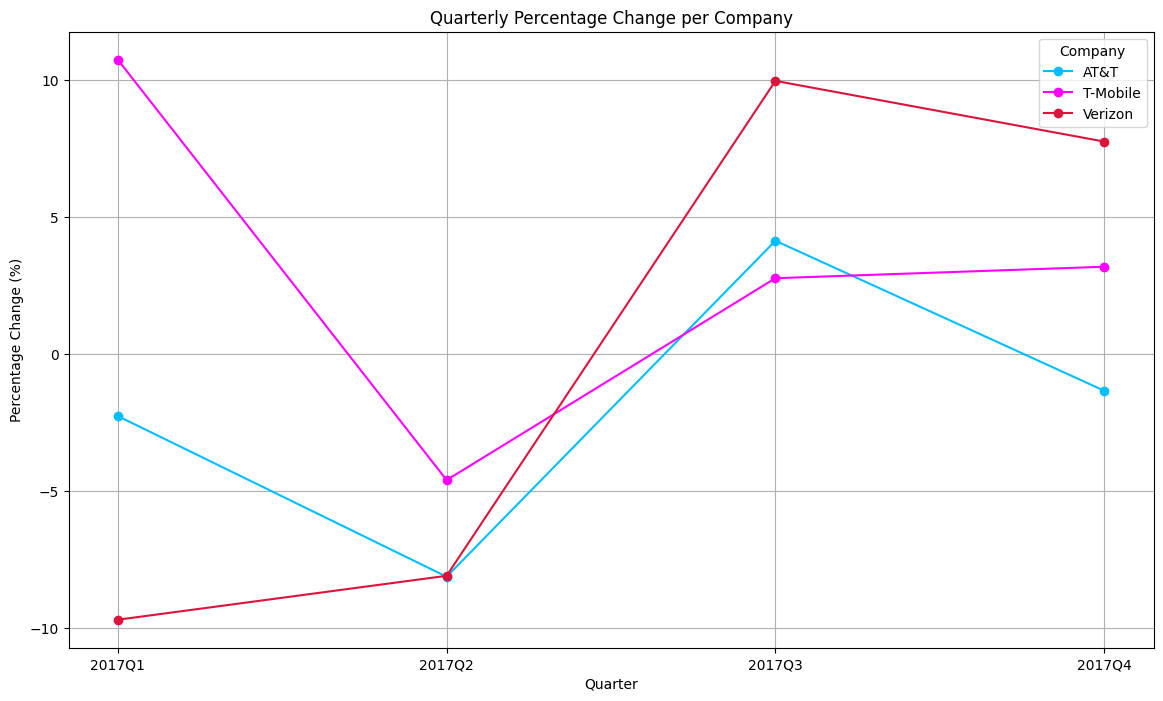

In [22]:
# Calculate the percentage change for each quarter
quarterly_percentage_change = filtered_data.groupby(['Company', 'Quarter'], as_index=False).apply(
    lambda x: pd.Series({
        'Percentage Change': (x.loc[x['Date'].idxmax()]['Adj. Close'] - x.loc[x['Date'].idxmin()]['Adj. Close']) / x.loc[x['Date'].idxmin()]['Adj. Close'] * 100
    })
)

# Plot the quarterly percentage change
plt.figure(figsize=(14, 8))
for company in quarterly_percentage_change['Company'].unique():
    company_data = quarterly_percentage_change[quarterly_percentage_change['Company'] == company]
    plt.plot(company_data['Quarter'].astype(str), company_data['Percentage Change'], marker='o', label=company, color=colors[company])

plt.title('Quarterly Percentage Change per Company')
plt.xlabel('Quarter')
plt.ylabel('Percentage Change (%)')
plt.legend(title='Company')
plt.grid(True)
plt.savefig('Plots/quarterly_percentage_change.png')
plt.show()

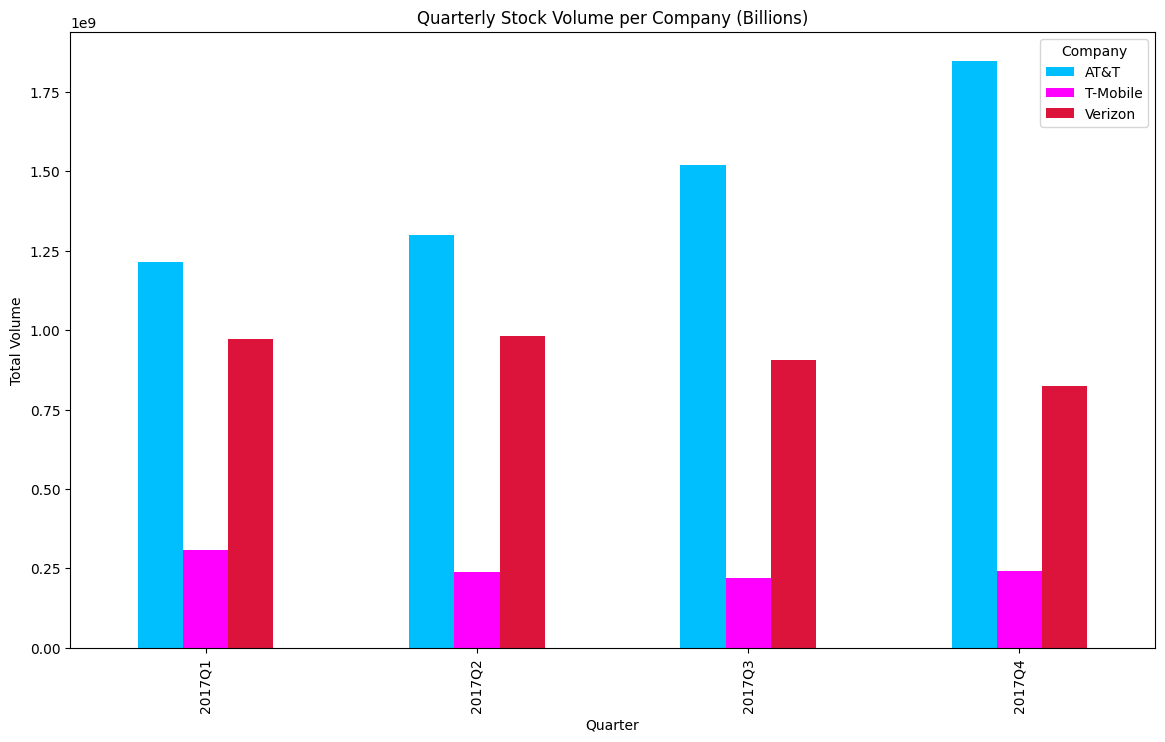

In [23]:
# Calculate the total stock volume for each quarter
quarterly_volume = filtered_data.groupby(['Quarter', 'Company'])['Volume'].sum().unstack().reset_index()

# Plot the quarterly stock volume
fig, ax = plt.subplots(figsize=(14, 8))
quarterly_volume.plot(kind='bar', x='Quarter', ax=ax, color=[colors[col] for col in quarterly_volume.columns[1:]])

plt.title('Quarterly Stock Volume per Company (Billions)')
plt.xlabel('Quarter')
plt.ylabel('Total Volume')
plt.legend(title='Company')
plt.savefig('Plots/quarterly_stock_volume.png')
plt.show()


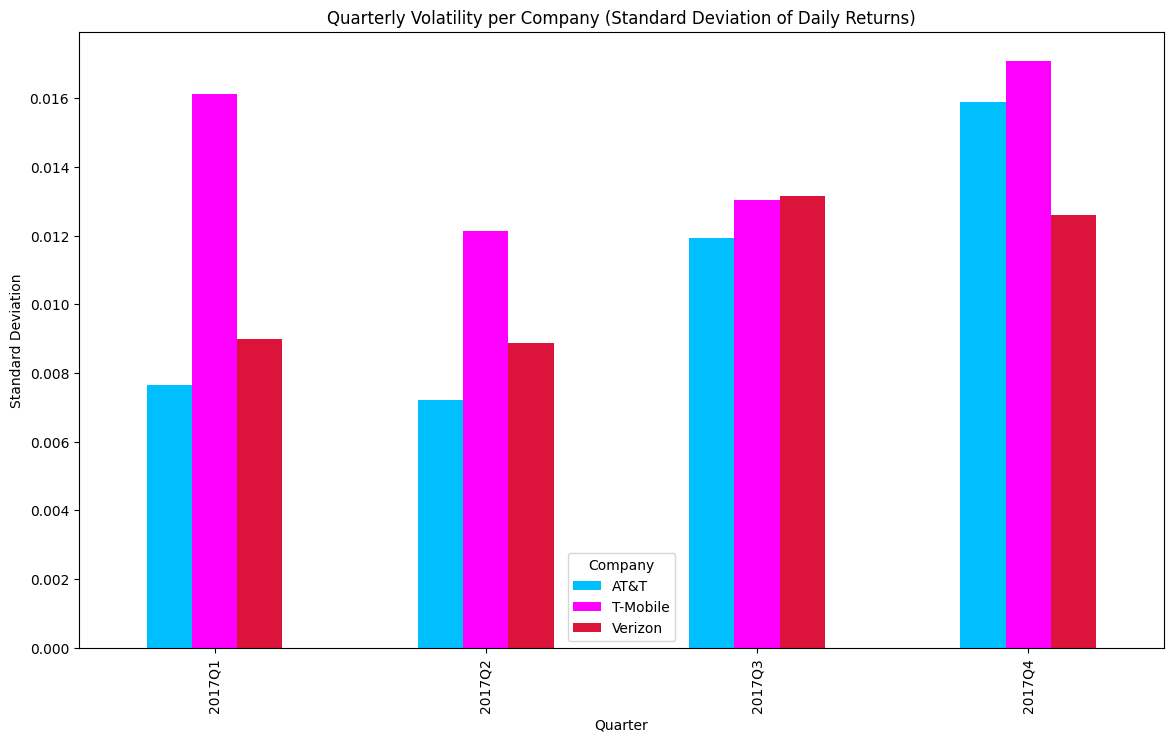

In [24]:
# Calculate daily returns
filtered_data['Daily Return'] = filtered_data.groupby('Company')['Adj. Close'].pct_change()

# Calculate the standard deviation of daily returns for each quarter
quarterly_volatility = filtered_data.groupby(['Company', 'Quarter'])['Daily Return'].std().unstack(level=0).reset_index()

# Plot the standard deviation (volatility)
fig, ax = plt.subplots(figsize=(14, 8))
quarterly_volatility.plot(kind='bar', x='Quarter', ax=ax, color=[colors[col] for col in quarterly_volatility.columns[1:]])

plt.title('Quarterly Volatility per Company (Standard Deviation of Daily Returns)')
plt.xlabel('Quarter')
plt.ylabel('Standard Deviation')
plt.legend(title='Company')
plt.savefig('Plots/quarterly_volatility.png')
plt.show()
